In [50]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
df = pd.read_csv('gas_price_dropna.csv')
df
df['Time_stamp'] = pd.to_datetime(df['Time_stamp']) # To convert dtype column 'DATE'
df = df.set_index('Time_stamp')
df.head()
# Datasource : https://www.kaggle.com/datasets/shenba/time-series-datasets

,Average
Time_stamp,
2022-11-28 14:00:02.123000+00:00,33.74235
2022-11-28 13:00:59.146000+00:00,14.27795
2022-11-28 12:00:56.875000+00:00,11.49080
2022-11-28 11:00:54.474000+00:00,11.69460
2022-11-28 10:00:52.330000+00:00,13.80000


In [13]:
df.index

DatetimeIndex(['2022-11-28 14:00:02.123000+00:00',
               '2022-11-28 13:00:59.146000+00:00',
               '2022-11-28 12:00:56.875000+00:00',
               '2022-11-28 11:00:54.474000+00:00',
               '2022-11-28 10:00:52.330000+00:00',
               '2022-11-28 09:00:50.925000+00:00',
               '2022-11-28 08:00:49.363000+00:00',
               '2022-11-28 07:00:47.907000+00:00',
               '2022-11-28 06:00:46.255000+00:00',
               '2022-11-28 05:00:44.674000+00:00',
               ...
               '2022-04-26 23:00:51.726000+00:00',
               '2022-04-26 22:00:48.675000+00:00',
               '2022-04-26 21:00:36.470000+00:00',
               '2022-04-26 20:00:08.945000+00:00',
               '2022-04-26 19:00:06.222000+00:00',
               '2022-04-26 18:00:02.576000+00:00',
               '2022-04-26 17:00:58.575000+00:00',
               '2022-04-26 16:01:05.379000+00:00',
               '2022-04-26 15:00:08.630000+00:00',
            

It was the first plot, and after seeing it I decided to dropout some extremely big values.  





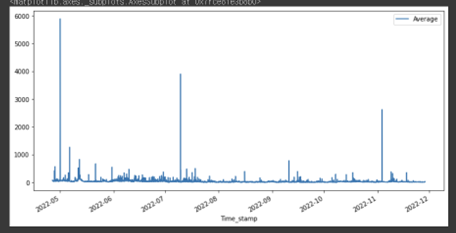

According to the original data, there are 6 values exceeds 1000, So I dropped them out. And the figure in the next code line is the plot of after dropout


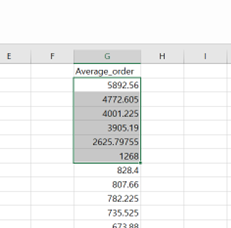

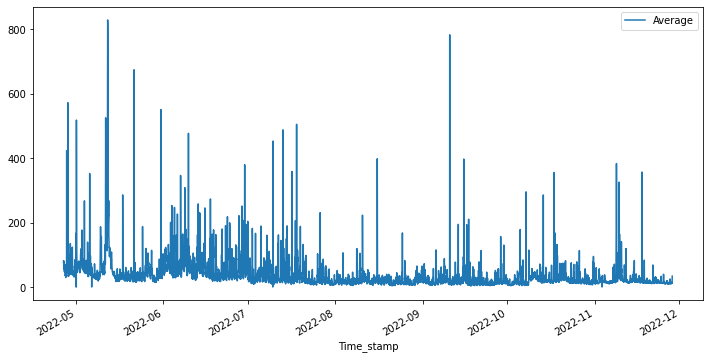

In [14]:
df.plot(figsize=(12,6))

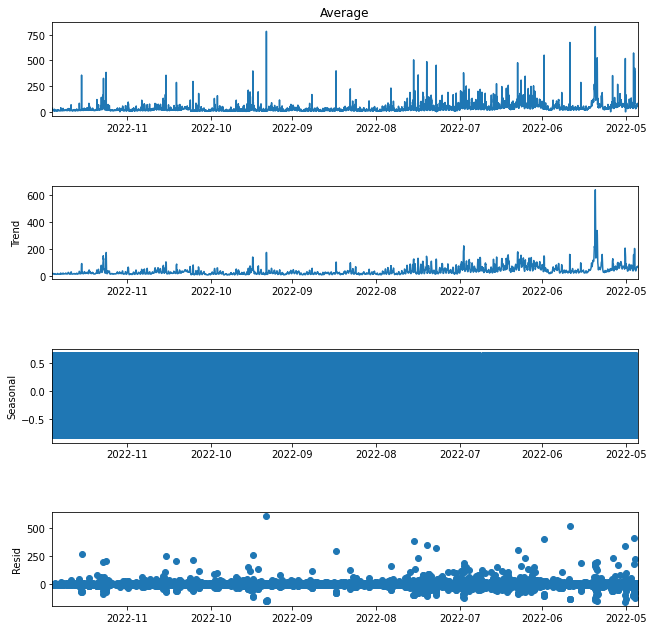

In [16]:
decomposition= sm.tsa.seasonal_decompose(df['Average'], model='additive',period=5)

ax = decomposition.plot()
ax.set_size_inches(10,10)

plt.show()

It seems that our data has no trend, and the seasonal part seems weird.

In [17]:
# time-series analysis plots

def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

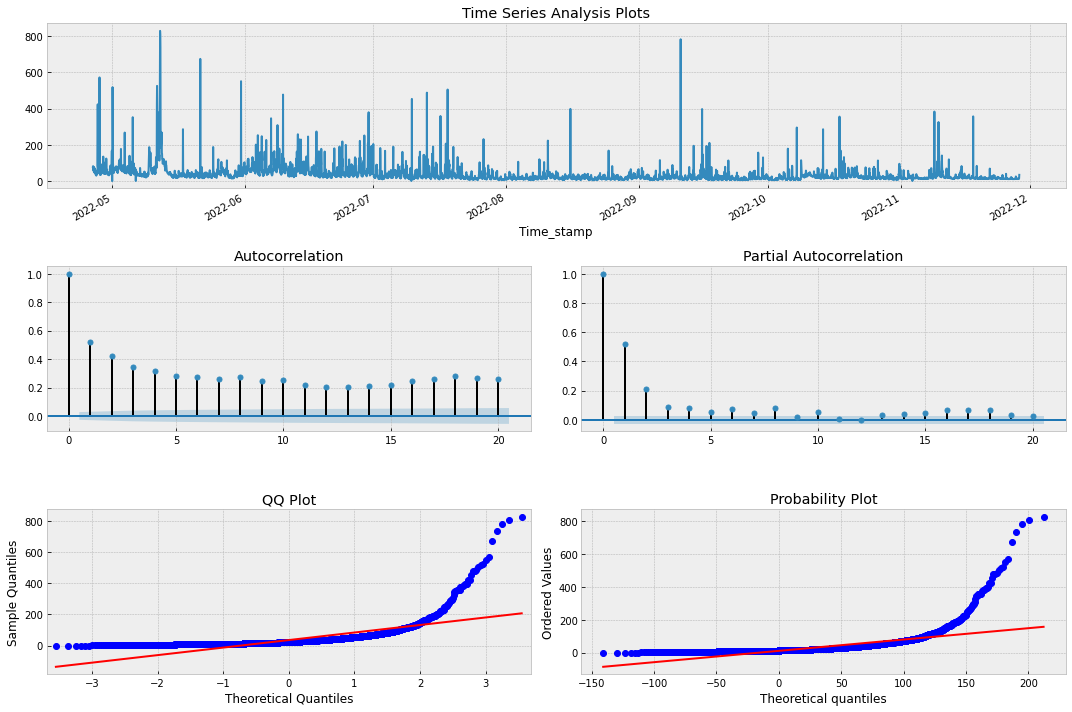

In [18]:
raw_data = tsplot(df['Average'], lags=20)

According to the ACF(all positive, far from the range), PACF(most values are out of range) and Q-Q plot & Probability plot(hard to say that our data follows the line), it seems that our data is not stationary. 

Since our data has no trend, I thought that using logarithm to adjust the variation would be better. And then I did differencing. 

In [19]:
df_log = np.log(df['Average'])

#1st differencing with logarithm
diff_df_log = df_log.diff(periods=1).iloc[1:]

#2nd differencing with logarithm
diff_2_df_log = df_log.diff(periods=2).iloc[2:]

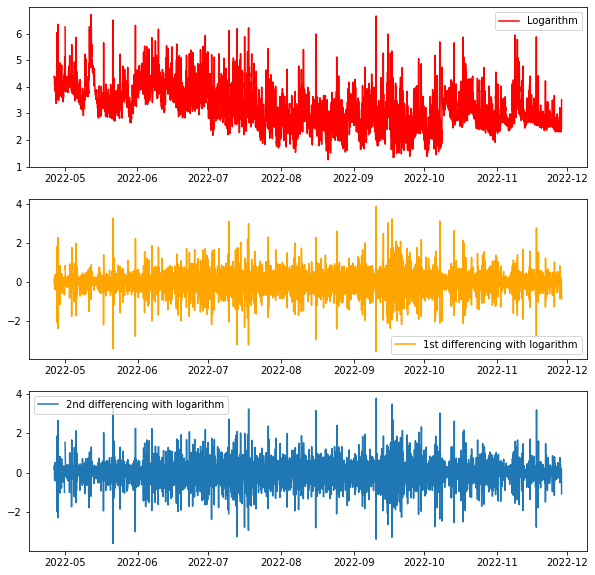

In [20]:
plt.figure(figsize=(10,10))

ax1 = plt.subplot(311)
ax1.plot(df_log, color='red')
ax1.legend(['Logarithm'])


ax2 = plt.subplot(312)
ax2.plot(diff_df_log, color='orange')
ax2.legend(['1st differencing with logarithm'])

ax3 =plt.subplot(313)
ax3.plot(diff_2_df_log)
ax3.legend(['2nd differencing with logarithm'])


However, in the ADF test part, there was an error like the figure below. "exog contians inf or nans.
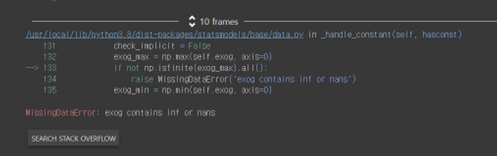

So I dropout the infinite values after checking whether the two dataframes (log + 1st diff, log + 2nd diff) both have infinite values.

In [26]:
np.any(~np.isfinite(diff_df_log),axis=0)

True

In [27]:
np.any(~np.isfinite(diff_2_df_log),axis=0)

True

In [46]:
# I Changed the name of variables
diff_df_log_1 = diff_df_log.copy().replace([np.inf, -np.inf], np.nan)
diff_df_log_1.dropna(inplace=True) 
np.any(~np.isfinite(diff_df_log_1),axis=0)

False

In [47]:
# I Changed the name of variables
diff_2_df_log_1 = diff_2_df_log.copy().replace([np.inf, -np.inf], np.nan)
diff_2_df_log_1.dropna(inplace=True)
np.any(~np.isfinite(diff_2_df_log_1),axis=0)

False

In [48]:
# ADF test

adf_test = adfuller(diff_df_log_1)
adf_test_ = adfuller(diff_2_df_log_1)

print('---1st differencing with logarithm---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])


print('\n---2nd differencing with logarithm---')
print('ADF Statistic: %f' % adf_test_[0])
print('Critical Values @ 0.05: %.2f' % adf_test_[4]['5%'])
print('p-value: %20.20f' % adf_test_[1])

---1st differencing with logarithm---
ADF Statistic: -14.445704
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000

---2nd differencing with logarithm---
ADF Statistic: -13.486195
Critical Values @ 0.05: -2.86
p-value: 0.00000000000000000000


According to the ADF test, the pvalue of both methods is 0. Thus our data is now stationary.

(+) According to the result of ADF for our original data, the p-value was 193.90 (> 0.05). It supports that our original data is not stationary.

In [52]:
adf_test = adfuller(df['Average'])
print('---1st differencing with logarithm---')
print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

---1st differencing with logarithm---
ADF Statistic: -6.406344
Critical Values @ 0.05: -2.86
p-value: 0.00000001939035690593


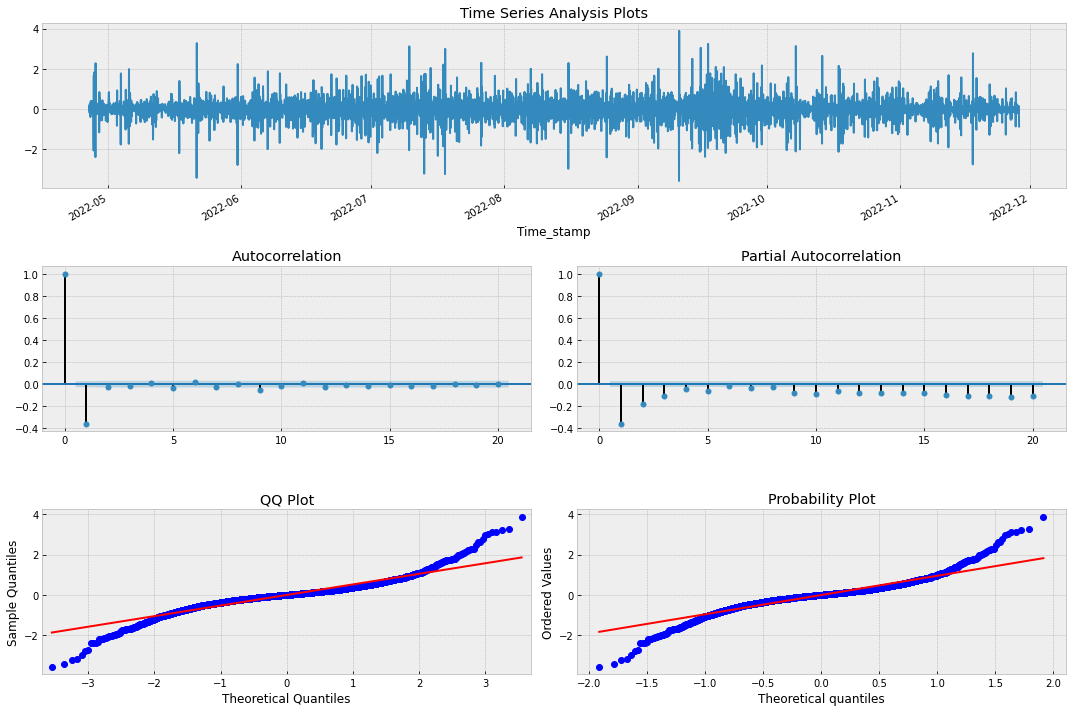

In [53]:
diff_2_plot= tsplot(diff_df_log_1, lags=20)

I think we can use MA(1), maybe for the log + 1st diff data

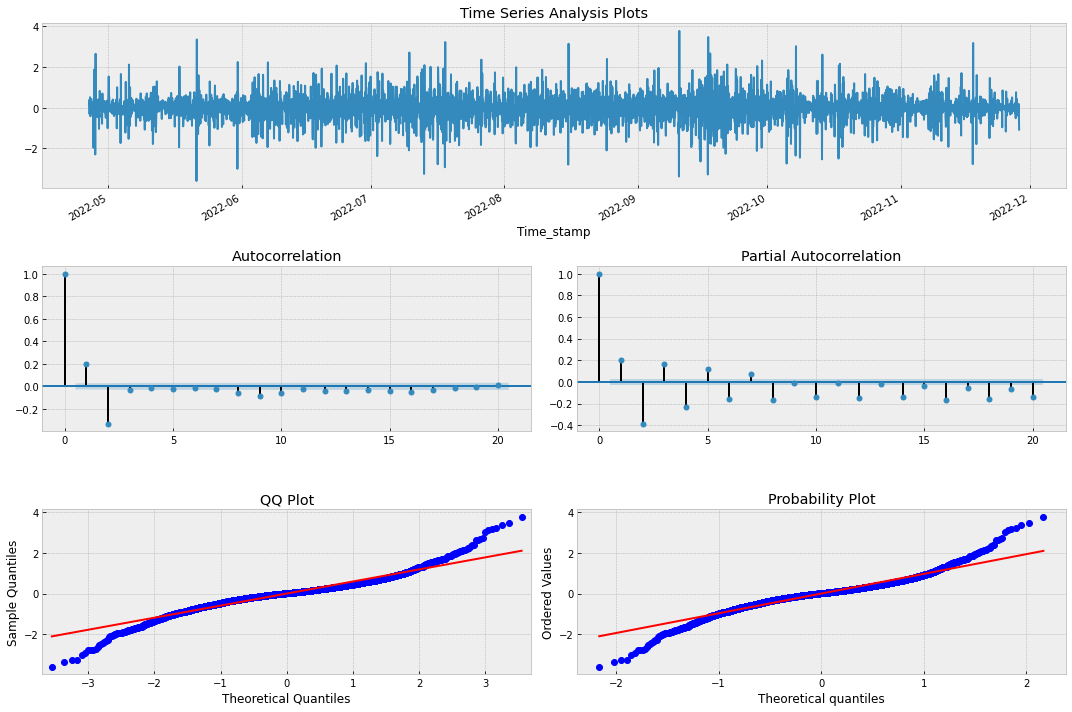

In [54]:
diff_2_plot= tsplot(diff_2_df_log_1, lags=20)

I think we can use MA(2), maybe for the log + 2nd diff data